C:\Users\julie\AppData\Local\Temp\ipykernel_24128\2822231232.py:66: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(LSF,[0],colors='r',linewidth=2)


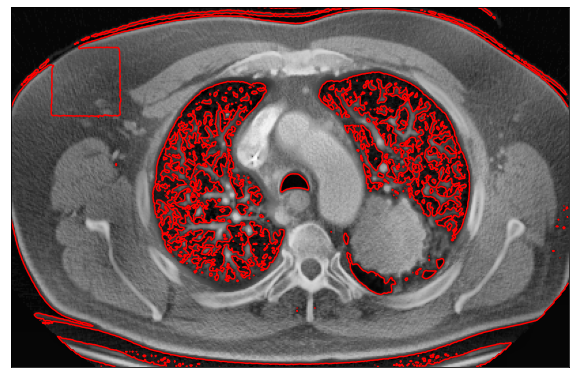

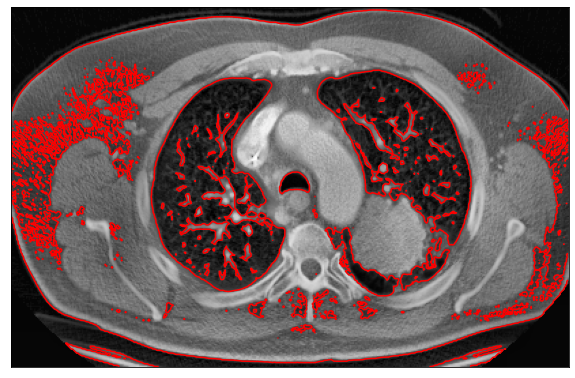

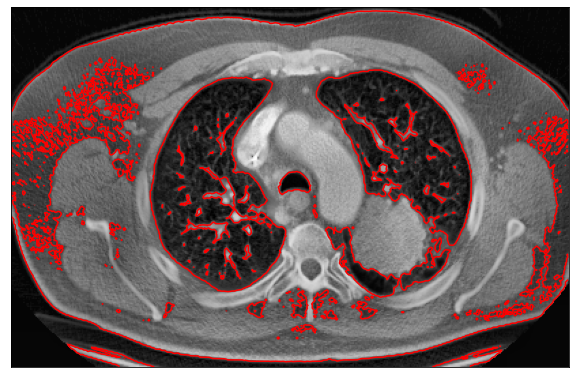

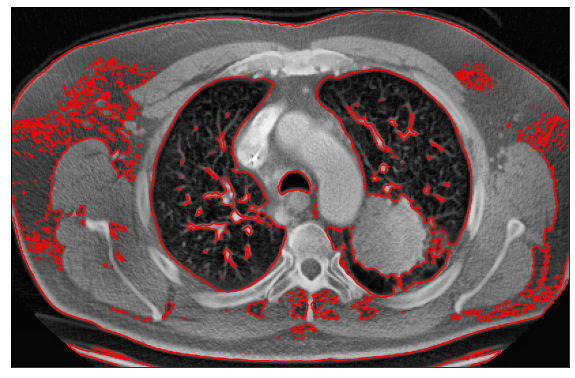

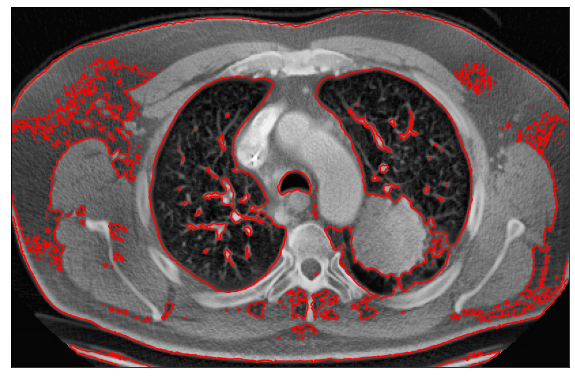

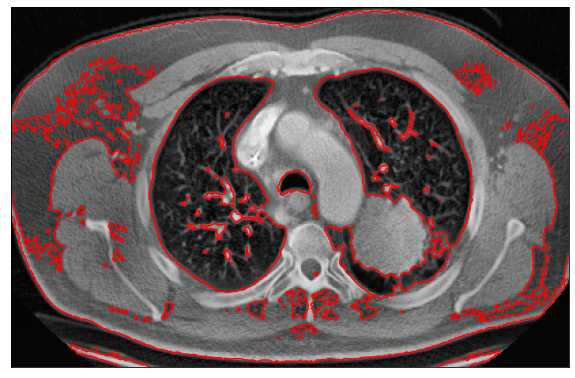

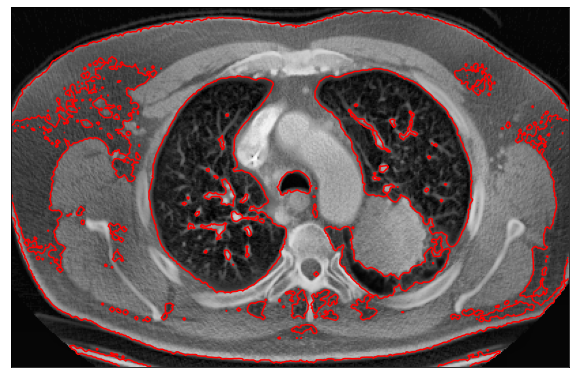

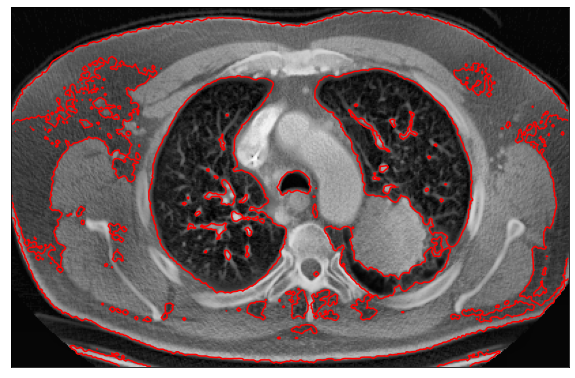

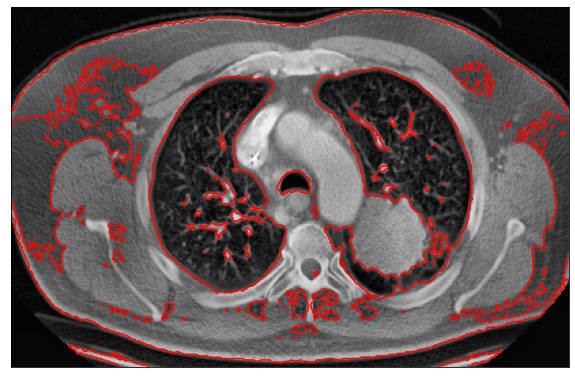

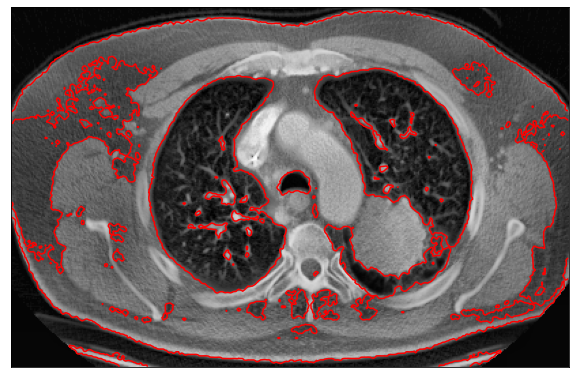

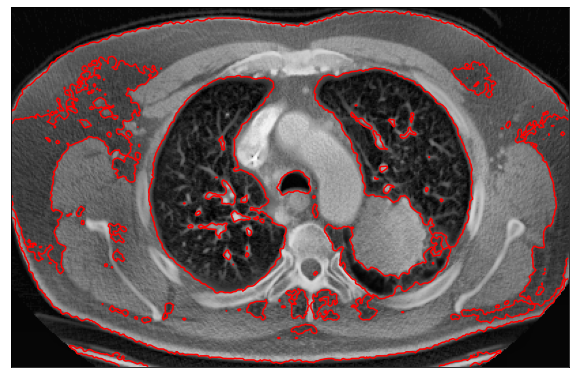

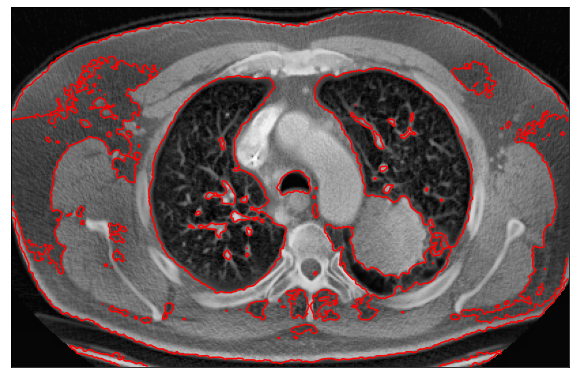

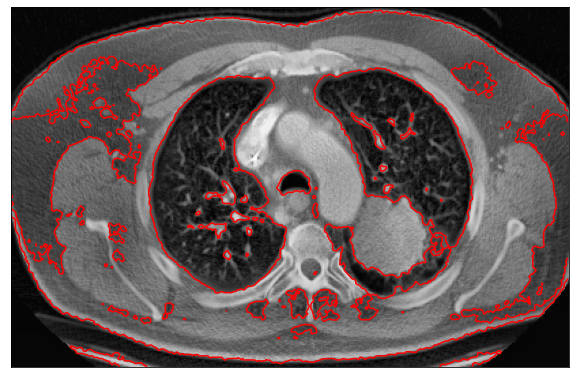

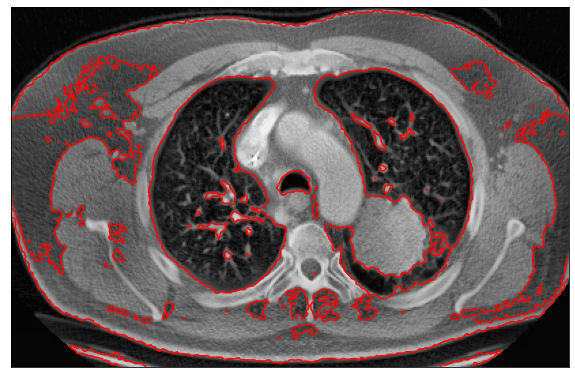

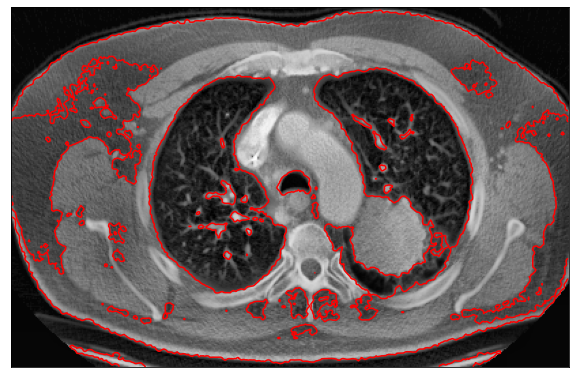

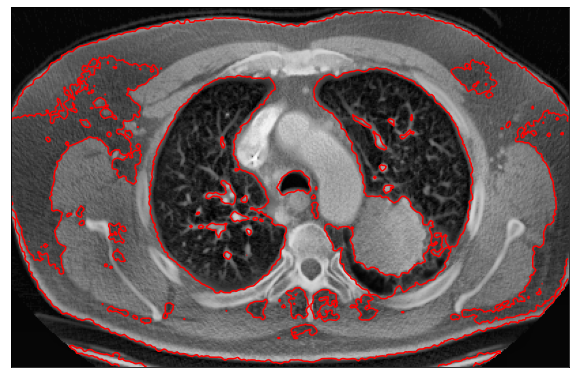

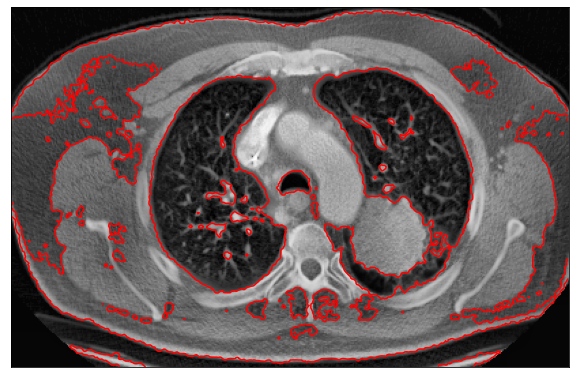

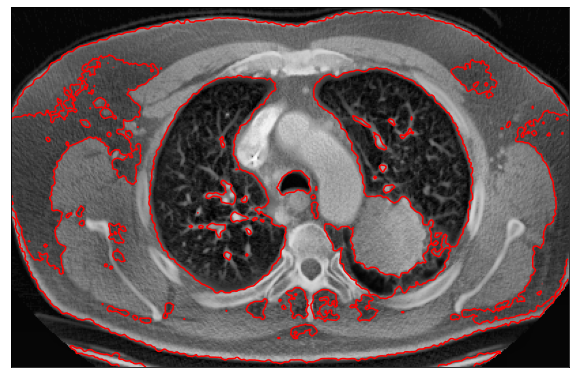

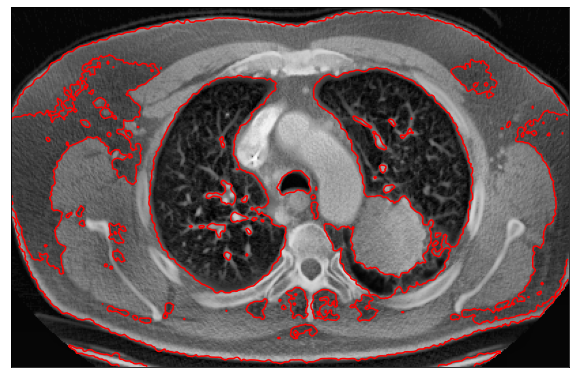

In [2]:
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from pylab import*

image = cv2.imread('Cancer_enh.png',0)
img=np.array(image,dtype=np.float64) 

IniLSF = np.ones((img.shape[0],img.shape[1]),img.dtype) 
IniLSF[30:80,30:80]= -1 
IniLSF=-IniLSF 


def mat_math (intput,str):
    output=intput 
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if str=="atan":
                output[i,j] = math.atan(intput[i,j]) 
            if str=="sqrt":
                output[i,j] = math.sqrt(intput[i,j]) 
    return output 


def CV (LSF, img, mu, nu, epison,step):

    Drc = (epison / math.pi) / (epison*epison+ LSF*LSF)
    Hea = 0.5*(1 + (2 / math.pi)*mat_math(LSF/epison,"atan")) 
    Iy, Ix = np.gradient(LSF) 
    s = mat_math(Ix*Ix+Iy*Iy,"sqrt") 
    Nx = Ix / (s+0.000001) 
    Ny = Iy / (s+0.000001) 
    Mxx,Nxx =np.gradient(Nx) 
    Nyy,Myy =np.gradient(Ny) 
    cur = Nxx + Nyy 
    Length = nu*Drc*cur 

    Lap = cv2.Laplacian(LSF,-1) 
    Penalty = mu*(Lap - cur) 

    s1=Hea*img 
    s2=(1-Hea)*img 
    s3=1-Hea 
    C1 = s1.sum()/ Hea.sum() 
    C2 = s2.sum()/ s3.sum() 
    CVterm = Drc*(-1 * (img - C1)*(img - C1) + 1 * (img - C2)*(img - C2)) 

    LSF = LSF + step*(Length + Penalty + CVterm) 
    #plt.imshow(s, cmap ='gray'),plt.show() 
    return LSF 


mu = 1
nu = 0.003 * 255 * 255 
num = 20
epison = 0.1
step = 0.1 
LSF=IniLSF 
for i in range(1,num):
    LSF = CV(LSF, img, mu, nu, epison,step) 
    if i % 1 == 0: 
        plt.figure(figsize=(10,10))  
        plt.imshow(image, cmap='gray'),plt.xticks([]), plt.yticks([])  
        plt.contour(LSF,[0],colors='r',linewidth=2) 
        plt.draw(),plt.show(block=False),plt.pause(0.01) 

Watershed

C:\Users\julie\AppData\Local\Temp\ipykernel_28980\1554536217.py:16: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  local_max = peak_local_max(distance_map, indices=False, min_distance=70, labels=thresh)


56894.0


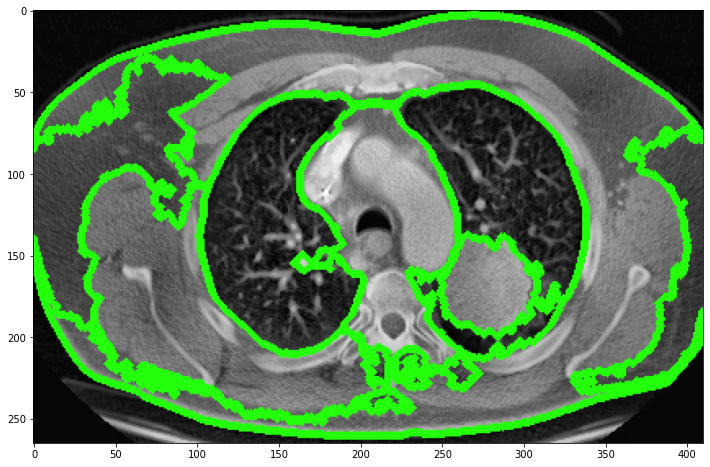

In [38]:
import cv2
import numpy as np
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import matplotlib.pyplot as plt

# Load in image, convert to gray scale, and Otsu's threshold
image = cv2.imread('Cancer_enh.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Compute Euclidean distance from every binary pixel
# to the nearest zero pixel then find peaks
distance_map = ndimage.distance_transform_edt(thresh)
local_max = peak_local_max(distance_map, indices=False, min_distance=70, labels=thresh)

# Perform connected component analysis then apply Watershed
markers = ndimage.label(local_max, structure=np.ones((3, 3)))[0]
labels = watershed(-distance_map, markers, mask=thresh)

# Iterate through unique labels
total_area = 0
for label in np.unique(labels):
    if label == 0:
        continue

    # Create a mask
    mask = np.zeros(gray.shape, dtype="uint8")
    mask[labels == label] = 255

    # Find contours and determine contour area
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    c = max(cnts, key=cv2.contourArea)
    area = cv2.contourArea(c)
    total_area += area
    cv2.drawContours(image, [c], -1, (36,255,12), 4)

print(total_area)
plt.imshow(image)
plt.show()

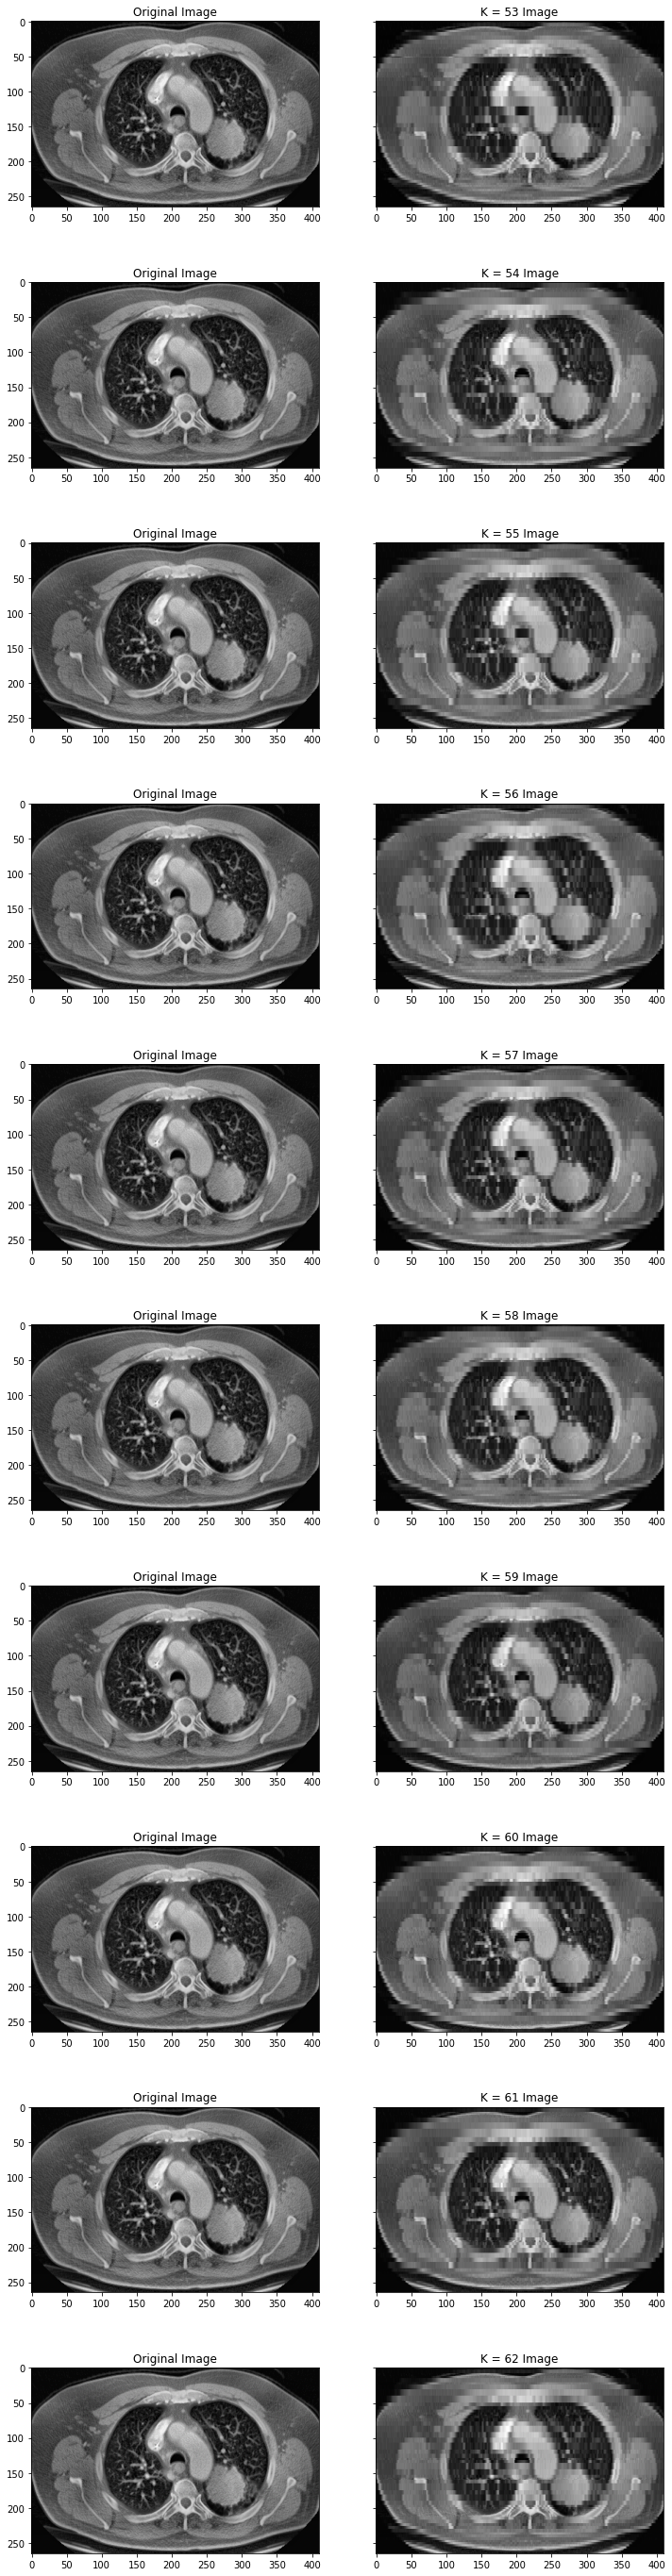

In [45]:
# imports
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12,50)

# load image
img = cv.imread('Cancer_enh.png',0)
#img = img.reshape((-1,3))
# convert to np.float32
Z = np.float32(img)

# define stopping criteria, number of clusters(K) and apply kmeans()
# TERM_CRITERIA_EPS : stop when the epsilon value is reached
# TERM_CRITERIA_MAX_ITER: stop when Max iteration is reached
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

fig, ax = plt.subplots(10,2, sharey=True)
x=0
for i in range(50,60):
    K = i+3
    # apply K-means algorithm
    flags = cv.KMEANS_RANDOM_CENTERS
    ret,label,center=cv.kmeans(Z,K,None,criteria, 10, flags)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    # plot the original image and K-means image
    ax[x, 1].imshow(res2, cmap='gray')
    ax[x,1].set_title('K = %s Image'%K)
    ax[x, 0].imshow(img, cmap='gray')
    ax[x,0].set_title('Original Image')
    x=x+1


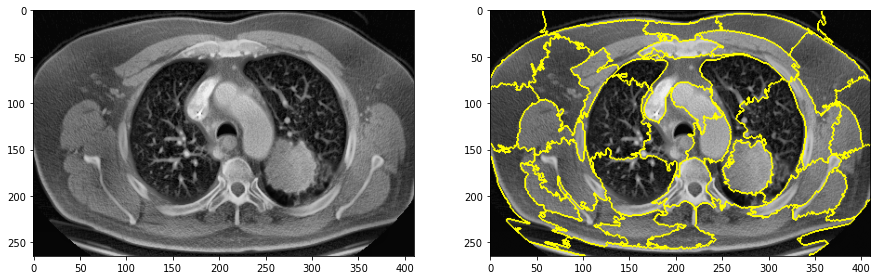

In [2]:
# Importing required boundaries
from skimage.segmentation import slic, mark_boundaries
import cv2
import matplotlib.pyplot as plt
 
# Setting the plot figure as 15, 15
plt.figure(figsize=(15, 15))
 
# Sample Image of scikit-image package
img=cv2.imread("Cancer_enh.png",0)/255
 
# Applying SLIC segmentation
# for the edges to be drawn over
img_segments = slic(img,n_segments=50,compactness=0.1)
 
plt.subplot(1, 2, 1)
 
# Plotting the original image
plt.imshow(img, cmap='gray')
 
# Detecting boundaries for labels
plt.subplot(1, 2, 2)
 
# Plotting the output of marked_boundaries
# function i.e. the image with segmented boundaries
plt.imshow(mark_boundaries(img, img_segments))

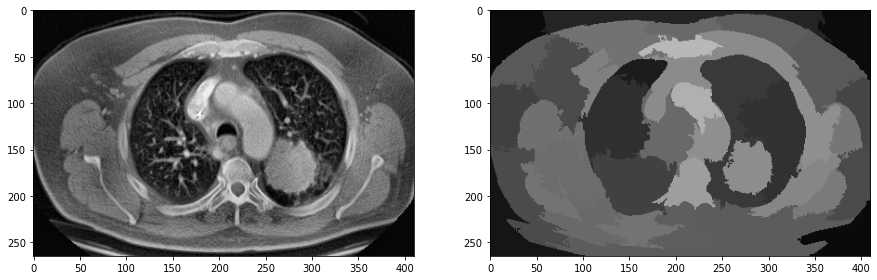

In [60]:
from skimage.segmentation import slic
import cv2
from skimage.color import label2rgb
import matplotlib.pyplot as plt

 
# Setting the plot size as 15, 15
plt.figure(figsize=(15,15))
 
# Sample Image of scikit-image package
img=cv2.imread("Cancer_enh.png",0)/255
 
# Applying Simple Linear Iterative
# Clustering on the image
img_segments = slic(img,n_segments=50,compactness=0.1)
plt.subplot(1,2,1)
 
# Plotting the original image
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
 
# Converts a label image into
# an RGB color image for visualizing
# the labeled regions.
plt.imshow(label2rgb(img_segments,
                     img,
                     kind = 'avg'))

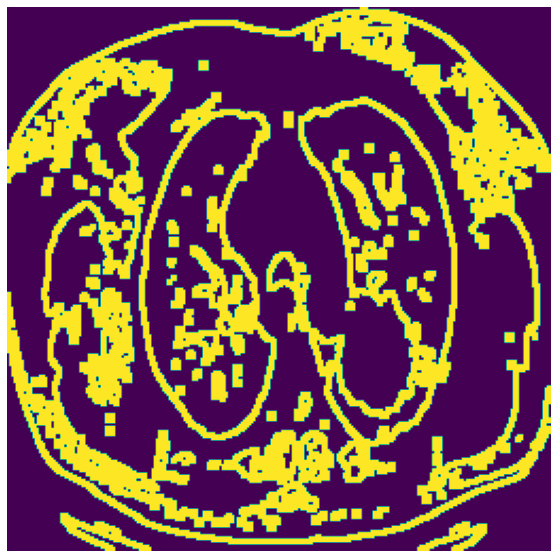

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sample_image = cv2.imread('Cancer_enh.png')
img = cv2.resize(sample_image,(256,256))

gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
_,thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY_INV)

edges = cv2.dilate(cv2.Canny(thresh,0,255),None)

cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
mask = np.zeros((256,256), np.uint8)
masked = cv2.drawContours(mask, [cnt],-1, 255, -1)

plt.figure(figsize=(20,10))
plt.axis('off')
plt.imshow(edges)

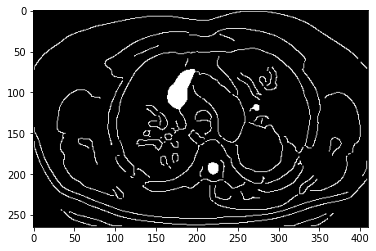

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2 ,os
from math import ceil
import pickle
import time
from skimage import io, feature
from skimage.color import rgb2gray
from scipy import ndimage as ndi
from skimage import morphology
from skimage.feature import canny
from skimage.restoration import estimate_sigma

foreground_value = 0
foreground_pixels=[]
segmented_images=[]


def read_image_files(dir):
    images = []
    filenames = os.listdir(dir)
    for filename in filenames:
        images.append(cv2.imread(dir + filename, 0))
    return images



def edge_based_segmentation(image):
    noise = estimate_sigma(image)
    edges = canny(image, sigma=3)
    filled = ndi.binary_fill_holes(edges)
    filled_cleaned = morphology.remove_small_objects(filled, 2)
    segmented_images.append(filled_cleaned)
    pixels=np.argwhere(filled_cleaned == foreground_value)
    foreground_pixels.append(pixels)
    return

img=cv2.imread('Cancer_enh.png',0)/255
edge_based_segmentation(img)

np.save('EdgeBasedSegmentation',foreground_pixels)
plt.imshow(segmented_images[0],'gray')

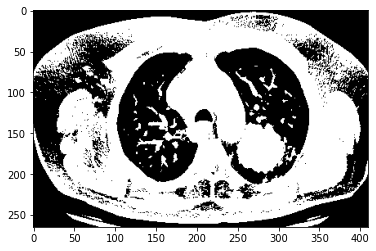

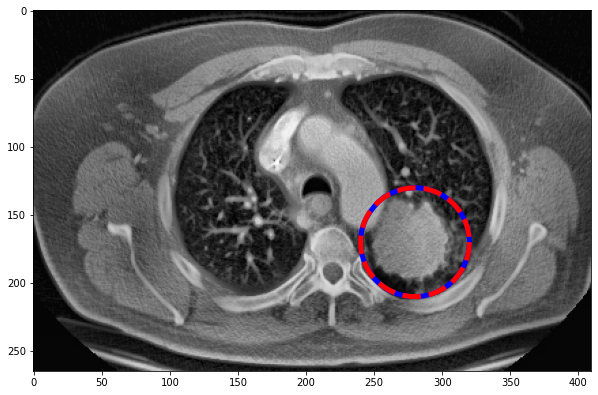

In [8]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
import cv2
 
# Sample Image of scikit-image package
img =cv2.imread("Cancer_enh.png",0)
 
 
# Localising the circle's center at 220, 110
x1 = 280 + 40*np.cos(np.linspace(0, 2*np.pi, 50))
x2 = 170 + 40*np.sin(np.linspace(0, 2*np.pi, 50))
 
# Generating a circle based on x1, x2
snake = np.array([x1, x2]).T


ret, thresh = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)     
                
plt.imshow(thresh, cmap='gray')   
 
# Computing the Active Contour for the given image
#alpha=lenght, beta=smoothness

astronaut_snake = active_contour(thresh, snake, w_line=0, w_edge=1, alpha=0.001,gamma=10)


fig = plt.figure(figsize=(10, 10))
 
# Adding subplots to display the markers
ax = fig.add_subplot(111)
 
# Plotting sample image
ax.imshow(img, cmap='gray')
 
# Plotting the face boundary marker
ax.plot(astronaut_snake[:, 0],
        astronaut_snake[:, 1],
        '-b', lw=5)
 
# Plotting the circle around face
ax.plot(snake[:, 0], snake[:, 1], '--r', lw=5)
